In [1]:
ugent_blauw = Color("#1E64C8")
ugent_geel = Color("#FFD200")
ugent_rood = Color("#DC4E28")

def T(alpha, t):
    cy = 1/sin(alpha)
    # beta = asin(t * sin(pi/2 - alpha))
    beta = t * alpha
    r = cot(alpha)
    return (r*sin(beta), cy - r*cos(beta))

/opt/sage/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


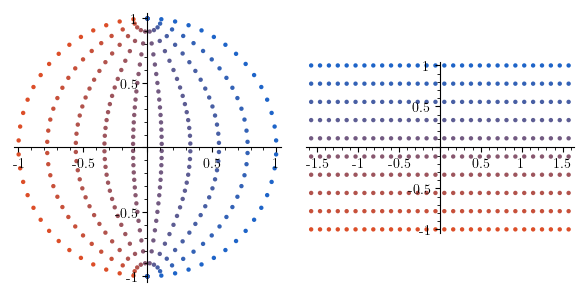

In [4]:
import matplotlib.pyplot as plt
import string
import numpy as np
import matplotlib as mpl

mpl.rc('font', family='serif', size=10, serif="Computer Modern Roman")
mpl.rc('text', usetex=True)

alphas = np.linspace(float(-pi/2), float(pi/2), 30)
ts = np.linspace(-1, 1, 10)

gt = Graphics()
go = Graphics()
for i, t in enumerate(ts):
    c = Color.blend(ugent_rood, ugent_blauw, i/(len(ts)-1))
    gt += list_plot([T(alpha, t) for alpha in alphas], color=c)
    go += list_plot([(alpha, t) for alpha in alphas], color=c)

base = 0.6
kwt = dict(aspect_ratio=1, figsize=(5*base,4*base))
kwo = dict(aspect_ratio=1, figsize=(5*base,4*base))

graphics_array([gt, go]).show(aspect_ratio=1)

# gt.save("disc_transformed.pdf", **kwt)
# go.save("disc_original.pdf", **kwo)

In [15]:
var('alpha, t')
sT = vector(SR, T(alpha,t))
sTa = diff(sT, alpha)
sTt = diff(sT, t)
sTaa = diff(sTa, alpha)
sTat = diff(sTa, t)
sTtt = diff(sTt, t)

ua, va = sTa
ut, vt = sTt
uaa, vaa = sTaa
uat, vat = sTat
utt, vtt = sTtt

M = (matrix([
        [ua, va, 0, 0, 0],
        [ut, vt, 0, 0, 0],
        [uaa, vaa, ua*ua, 2*ua*va, va*va],
        [uat, vat, ua*ut, (ut*va+ua*vt), va*vt],
        [utt, vtt, ut*ut, 2*ut*vt, vt*vt]
]).solve_left(vector([0,0,1,0,1]))).simplify_full()
M

(-sin(alpha)^5/(cos(alpha*t)^2*cos(alpha)^3 - 2*cos(alpha*t)*cos(alpha)^2 + cos(alpha)), ((alpha*cos(alpha)*sin(alpha)^5 - 2*sin(alpha)^6 + 2*sin(alpha)^4)*t*cos(alpha*t) - (alpha*sin(alpha)^5 + 2*cos(alpha)*sin(alpha)^4)*t + 2*(cos(alpha)*sin(alpha)^3 + (sin(alpha)^5 - sin(alpha)^3)*cos(alpha*t))*sin(alpha*t))/(alpha^2*cos(alpha*t)^3*cos(alpha)^4 - 3*alpha^2*cos(alpha*t)^2*cos(alpha)^3 + 3*alpha^2*cos(alpha*t)*cos(alpha)^2 - alpha^2*cos(alpha)), sin(alpha)^4/(cos(alpha*t)^2*cos(alpha)^2 - 2*cos(alpha*t)*cos(alpha) + 1), -2*(t*sin(alpha)^4 - sin(alpha*t)*sin(alpha)^3)/(alpha*cos(alpha*t)^2*cos(alpha)^2 - 2*alpha*cos(alpha*t)*cos(alpha) + alpha), -(2*cos(alpha*t)*cos(alpha)*sin(alpha)^2 + sin(alpha)^4 + (sin(alpha)^6 - sin(alpha)^4)*t^2 - 2*(sin(alpha)^5 - sin(alpha)^3)*t*sin(alpha*t) - 2*sin(alpha)^2)/(alpha^2*cos(alpha*t)^2*cos(alpha)^4 - 2*alpha^2*cos(alpha*t)*cos(alpha)^3 + alpha^2*cos(alpha)^2))

In [16]:
M(0.3,0.1)

(-1.16025637523858, 0.261669485684224, 3.75079343821723, 0.0375247918185031, 1.06330402439258)